In [1]:
import sys  
sys.path.insert(0, '../../build/lib')

import py_aff3ct
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Constants
N   = 4096   # Packet length in bits
bps = 4      # Bits per Symbols   
Ns  = N//bps # Packet size in symbols
EsN0dB = 7

In [3]:
def Jm1(I):
    sigma = np.zeros(I.shape)
    msk_l = I <= np.ones(I.shape) * 0.3646
    msk_u = I >  np.ones(I.shape) * 0.3646
    sigma[msk_l] = 1.09542 * I[msk_l] ** 2 + 0.214217 * I[msk_l] + 2.33737 * np.sqrt(I[msk_l])
    sigma[msk_u] = -0.706692 * np.log(0.386013*(1.0-I[msk_u])) + 1.75017*I[msk_u]
    return sigma

def J(sigma):
    I = np.zeros(sigma.shape)
    msk_l = sigma <= np.ones(sigma.shape) * 1.6363
    msk_u = sigma >  np.ones(sigma.shape) * 1.6363
    I[msk_l] = -0.0421061 * sigma[msk_l]**3 + 0.209252 * sigma[msk_l]**2 + -0.00640081 * sigma[msk_l]
    I[msk_u] = 1 - np.exp(0.00181491 * sigma[msk_u]**3 -0.142675 * sigma[msk_u]**2 -0.0822054 * sigma[msk_u] + 0.0549608)
    I[sigma >= 10] = 1.0
    return I

In [4]:
# Build the modules for the "classical" sequence
src    = py_aff3ct.module.source.Source_random(N)        # Build source
cstl   = py_aff3ct.tools.constellation.Constellation_user('../../lib/aff3ct/conf/mod/16QAM_ANTI_GRAY.mod')
#cstl   = py_aff3ct.tools.constellation.Constellation_QAM(bps)
mdm    = py_aff3ct.module.modem.Modem_generic(N, cstl)   # Build the modem
chn    = py_aff3ct.module.channel.Channel_AWGN_LLR(2*Ns) # Build the channel (Ns complex symbols = 2Ns real dims)

# Build the modules for the "a priori" sequence
mdm_a  = py_aff3ct.module.modem.Modem_BPSK_fast(N)    # Build the modem
chn_a  = py_aff3ct.module.channel.Channel_AWGN_LLR(N) # Build the channel (Ns complex symbols = 2Ns real dims)

mnt_a    = py_aff3ct.module.monitor.Monitor_MI(N,10000) # Build the monitor (Evaluating Mutual Information)
mnt_e    = py_aff3ct.module.monitor.Monitor_MI(N,10000) # Build the monitor (counting errors)

In [5]:
# "Normal" sequence binding
mdm  [         'modulate::X_N1'  ] = src  [   'generate::U_K' ] # Source     -> Modulation
chn  [        'add_noise::X_N'   ] = mdm  [   'modulate::X_N2'] # Modulation -> Channel
mdm  [      'tdemodulate::Y_N1'  ] = chn  [  'add_noise::Y_N' ] # Channel    -> Demodulation

# "a priori" sequence binding
mdm_a[         'modulate::X_N1'  ] = src  [   'generate::U_K' ] # Source     -> BPSK
chn_a[        'add_noise::X_N'   ] = mdm_a[   'modulate::X_N2'] # BPSK       -> AWGN Channel
mdm_a[       'demodulate::Y_N1'  ] = chn_a[  'add_noise::Y_N' ] # Channel    -> BPSK demodulation (LLR computation)
mdm  [      'tdemodulate::Y_N2'  ] = mdm_a[ 'demodulate::Y_N2'] # BPSK demod -> turbo demodulation

# Monitor a priori mututal information
mnt_a['get_mutual_info::X'  ] = src  [   'generate::U_K' ]
mnt_a['get_mutual_info::Y'  ] = mdm_a[ 'demodulate::Y_N2']

# Monitor extrinsic mututal information
mnt_e['get_mutual_info::X'  ] = src  [   'generate::U_K' ]
mnt_e['get_mutual_info::Y'  ] = mdm  ['tdemodulate::Y_N3']

In [6]:
sigma = np.ndarray(shape = (1,1),  dtype = np.float32)
sigma[0] = 2*10**(-EsN0dB/10)

chn[  'add_noise::CP'].bind(sigma)
mdm['tdemodulate::CP'].bind(sigma)

sigma_a = np.ndarray(shape = (1,1),  dtype = np.float32)
sigma_a[0] = 1

chn_a[  'add_noise::CP'].bind(sigma_a)
mdm_a[ 'demodulate::CP'].bind(sigma_a)

In [7]:
seq = py_aff3ct.tools.pipeline.Pipeline(
    [src["generate"         ]],
    [],
    [
        [[src["generate"]], [],[mnt_a["get_mutual_info"], mnt_e["get_mutual_info"]]],
        [[mnt_a["get_mutual_info"], mnt_e["get_mutual_info"]], [], []]
    ],
    [14, 1],
    [1000],
    [False])

In [8]:
I_A_0 = np.arange(0.0001,1.0,0.1)
I_A_0 = np.append(I_A_0, 0.99999)
# Convert I_A into variance values for the AWGN channel
sigma_a_vec = 2/Jm1(I_A_0)

In [9]:
# Compute the EXIT chart
I_A = np.zeros(sigma_a_vec.shape)
I_E = np.zeros(sigma_a_vec.shape)
print("---------|---------|----------")
print("  I_A_0  |   I_A   |    I_E   ")
print("---------|---------|----------")
for i in range(len(sigma_a_vec)):
    mnt_a.reset()
    mnt_e.reset()
    
    sigma_a[0] = sigma_a_vec[i]
    seq.exec()
    I_A[i] = mnt_a.get_MI()
    I_E[i] = mnt_e.get_MI()
    print("%8.2f | %7.2f | %7.2f "%(I_A_0[i], I_A[i], I_E[i]))


---------|---------|----------
  I_A_0  |   I_A   |    I_E   
---------|---------|----------
    0.00 |    0.00 |    0.10 
    0.10 |    0.10 |    0.18 
    0.20 |    0.20 |    0.27 
    0.30 |    0.30 |    0.35 
    0.40 |    0.40 |    0.43 
    0.50 |    0.50 |    0.51 
    0.60 |    0.60 |    0.59 
    0.70 |    0.70 |    0.66 
    0.80 |    0.80 |    0.72 
    0.90 |    0.90 |    0.78 
    1.00 |    1.00 |    0.82 


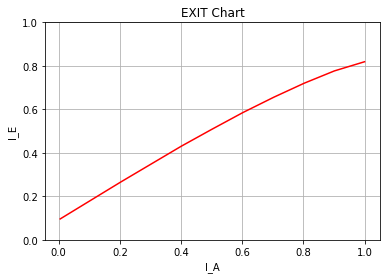

In [11]:
fig = plt.figure()
plt.title("EXIT Chart")
plt.xlabel("I_A")
plt.ylabel("I_E")
plt.grid()
plt.plot(I_A, I_E, 'r-')
plt.ylim((0, 1))
plt.show()

In [22]:
J(np.array([100]))

array([1.])